In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score

# import matplotlib.pyplot as plt

from sklearn.externals import joblib

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
import pandas as pd
import numpy as np

In [15]:
import time

### Model trainig without hyper-parameter tuning

In [6]:
def train_model(train, valid, test, features,target):
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train.copy(), valid.copy(), test.copy()
#     out_path = params['out_path']
#     predictors, target = list(params['predictors']), params['target']
    predictors, target = features, target
#     alg = XGBClassifier(
#                 learning_rate =params['learning_rate'],
#                 n_estimators=params['n_estimators'],
#                 max_depth=params['max_depth'],
#                 min_child_weight=params['min_child_weight'],
#                 gamma=params['gamma'],
#                 subsample=params['subsample'],
#                 colsample_bytree=params['colsample_bytree'],
#                 objective= 'binary:logistic',
#                 scale_pos_weight=params['scale_pos_weight'],
#                 seed=27)

    alg = XGBClassifier( colsample_bytree=0.8, gamma=0, learning_rate=0.1,
    max_depth=5, min_child_weight=1, n_estimators=5000, objective='binary:logistic',
    reg_alpha=0, reg_lambda=0, scale_pos_weight=(len(train) -train[df_target].sum())/train[df_target].sum(),
    seed=7, silent=True, subsample=0.8,n_jobs=5)
    
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    return alg

In [6]:
## Model developed to be used in for loop without print statement

def model_fit_hyperopt(params):
    
#     attempt_count += 1

    ### Asssigning default parameters
#     useTrainCV = False
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train.copy(), valid.copy(), test.copy()
#     out_path = params['out_path']
    predictors, target = list(params['predictors']), params['target']
    
    alg = XGBClassifier(
                learning_rate =params['learning_rate'],
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                gamma=params['gamma'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                objective= 'binary:logistic',
                scale_pos_weight=params['scale_pos_weight'],
                seed=27)

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(train_c[predictors].values, label=train_c[target].values)
#         xgtest = xgb.DMatrix(valid_c[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics = 'auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
#         ne_new = n_estimators=cvresult.shape[0]
#         alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params, 'model':alg}

In [7]:
def get_best_model_xgb(space, train, valid, test):
    
#     f = open(os.path.join(out_path, "hyperopt_logs.txt"), "w+")
#     f.close()

    trials=Trials()
    best = fmin(model_fit_hyperopt, space, algo=tpe.suggest, max_evals=75, trials=trials)
    
    return trials.best_trial['result']['model'], trials.best_trial['result']

In [8]:
# def train_validate_test_split(df, train_percent=.60, validate_percent=.20, seed=42):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

In [7]:
def data(df,target):
    processed_df = pd.get_dummies(df,sparse=True)
    df_features = list(set(processed_df.columns) - set([target]))
#     train, valid, test = train_validate_test_split(processed_df)
    train = processed_df.ix[train_o.index]
    valid = processed_df.ix[valid_o.index]
    test = processed_df.ix[test_o.index]
    return train, valid, test, df_features, target

In [8]:
train_o = pd.read_csv('../data/train_insurance.csv',index_col = 0)
valid_o = pd.read_csv('../data/valid_insurance.csv',index_col = 0)
test_o = pd.read_csv('../data/test_insurance.csv',index_col = 0)

In [9]:
all_data = pd.concat([train_o,valid_o,test_o])

In [10]:
all_data.drop(['StartedFlag','EstimateTotal'],axis=1,inplace=True)

In [11]:
train, valid, test, df_features, df_target = data(all_data,target='NewEstimateTotal')

# space = {'learning_rate': hp.choice('learning_rate',[0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]),
#                      'n_estimators': 5000,
#                      'min_child_weight': hp.choice('min_child_weight', [0,1,2,3,4,5,6,7]),
#                      'max_depth': hp.choice('max_depth', [3,4,5,6,7,8,9,10]),
#                      'gamma': hp.choice('gamma', [0,1,5,10]),
#                      'subsample': hp.choice('subsample',np.arange(0.4,1.05,0.1)),
#                      'colsample_bytree': hp.choice('colsample_bytree',np.arange(0.5,1.05,0.1)),
#                      'scale_pos_weight': (len(train) -train[df_target].sum())/train[df_target].sum(),
#                      'predictors': df_features,
#                      'target': df_target
#         }

# best_first_trained, first_trials = get_best_model_xgb(space, train, valid, test)

/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stabl

In [ ]:
start_time = time.time()
model = train_model(train.head(300000), valid.head(60000), test, df_features, df_target)

with open('insurance_classify_300000_estimate_total.pkl', 'wb') as f:
    pickle.dump(model, f)

f = open("estimate_total_300000.txt", "w")
f.write("Took {} seconds".format(time.time()-start_time))
f.close() 

[0]	validation_0-auc:0.823618
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.833442
[2]	validation_0-auc:0.834768
[3]	validation_0-auc:0.835263
[4]	validation_0-auc:0.83574
[5]	validation_0-auc:0.836054
[6]	validation_0-auc:0.837514
[7]	validation_0-auc:0.837592
[8]	validation_0-auc:0.83836
[9]	validation_0-auc:0.838908
[10]	validation_0-auc:0.839266
[11]	validation_0-auc:0.839569
[12]	validation_0-auc:0.839984
[13]	validation_0-auc:0.840318
[14]	validation_0-auc:0.84067
[15]	validation_0-auc:0.84094
[16]	validation_0-auc:0.841496
[17]	validation_0-auc:0.841841
[18]	validation_0-auc:0.842122
[19]	validation_0-auc:0.842454
[20]	validation_0-auc:0.842867
[21]	validation_0-auc:0.843547
[22]	validation_0-auc:0.844104
[23]	validation_0-auc:0.844622
[24]	validation_0-auc:0.844951
[25]	validation_0-auc:0.845493
[26]	validation_0-auc:0.845692
[27]	validation_0-auc:0.846
[28]	validation_0-auc:0.846456
[29]	validation_0-auc:0.84685
[30]	validation_0-auc:0.

[259]	validation_0-auc:0.873739
[260]	validation_0-auc:0.873764
[261]	validation_0-auc:0.873779
[262]	validation_0-auc:0.873806
[263]	validation_0-auc:0.873827
[264]	validation_0-auc:0.873884
[265]	validation_0-auc:0.873926
[266]	validation_0-auc:0.873958
[267]	validation_0-auc:0.874045
[268]	validation_0-auc:0.874032
[269]	validation_0-auc:0.874078
[270]	validation_0-auc:0.874108
[271]	validation_0-auc:0.874137
[272]	validation_0-auc:0.874245
[273]	validation_0-auc:0.874269
[274]	validation_0-auc:0.87431
[275]	validation_0-auc:0.874327
[276]	validation_0-auc:0.874377
[277]	validation_0-auc:0.87444
[278]	validation_0-auc:0.874479
[279]	validation_0-auc:0.874511
[280]	validation_0-auc:0.874556
[281]	validation_0-auc:0.874594
[282]	validation_0-auc:0.874615
[283]	validation_0-auc:0.874662
[284]	validation_0-auc:0.874688
[285]	validation_0-auc:0.874779
[286]	validation_0-auc:0.874824
[287]	validation_0-auc:0.87486
[288]	validation_0-auc:0.874894
[289]	validation_0-auc:0.874931
[290]	valid

[516]	validation_0-auc:0.88266
[517]	validation_0-auc:0.882669
[518]	validation_0-auc:0.882687
[519]	validation_0-auc:0.882697
[520]	validation_0-auc:0.882714
[521]	validation_0-auc:0.882732
[522]	validation_0-auc:0.882743
[523]	validation_0-auc:0.882784
[524]	validation_0-auc:0.882801
[525]	validation_0-auc:0.882917
[526]	validation_0-auc:0.882947
[527]	validation_0-auc:0.882966
[528]	validation_0-auc:0.882978
[529]	validation_0-auc:0.883027
[530]	validation_0-auc:0.88304
[531]	validation_0-auc:0.883057
[532]	validation_0-auc:0.883084
[533]	validation_0-auc:0.883116
[534]	validation_0-auc:0.883261
[535]	validation_0-auc:0.883274
[536]	validation_0-auc:0.883281
[537]	validation_0-auc:0.883291
[538]	validation_0-auc:0.883308
[539]	validation_0-auc:0.883334
[540]	validation_0-auc:0.883347
[541]	validation_0-auc:0.883376
[542]	validation_0-auc:0.883392
[543]	validation_0-auc:0.883405
[544]	validation_0-auc:0.883437
[545]	validation_0-auc:0.883454
[546]	validation_0-auc:0.883488
[547]	vali

[773]	validation_0-auc:0.887851
[774]	validation_0-auc:0.88786
[775]	validation_0-auc:0.887874
[776]	validation_0-auc:0.887883
[777]	validation_0-auc:0.887887
[778]	validation_0-auc:0.888006
[779]	validation_0-auc:0.888014
[780]	validation_0-auc:0.888058
[781]	validation_0-auc:0.888061
[782]	validation_0-auc:0.888108
[783]	validation_0-auc:0.888191
[784]	validation_0-auc:0.888193
[785]	validation_0-auc:0.888205
[786]	validation_0-auc:0.888208
[787]	validation_0-auc:0.888224
[788]	validation_0-auc:0.888229
[789]	validation_0-auc:0.888241
[790]	validation_0-auc:0.888251
[791]	validation_0-auc:0.888262
[792]	validation_0-auc:0.888263
[793]	validation_0-auc:0.888266
[794]	validation_0-auc:0.888272
[795]	validation_0-auc:0.88828
[796]	validation_0-auc:0.888286
[797]	validation_0-auc:0.888293
[798]	validation_0-auc:0.888307
[799]	validation_0-auc:0.888317
[800]	validation_0-auc:0.888323
[801]	validation_0-auc:0.888372
[802]	validation_0-auc:0.88838
[803]	validation_0-auc:0.888388
[804]	valid

[1030]	validation_0-auc:0.891321
[1031]	validation_0-auc:0.891324
[1032]	validation_0-auc:0.891324
[1033]	validation_0-auc:0.891329
[1034]	validation_0-auc:0.891334
[1035]	validation_0-auc:0.891337
[1036]	validation_0-auc:0.89134
[1037]	validation_0-auc:0.891351
[1038]	validation_0-auc:0.891356
[1039]	validation_0-auc:0.891361
[1040]	validation_0-auc:0.891378
[1041]	validation_0-auc:0.891381
[1042]	validation_0-auc:0.891378
[1043]	validation_0-auc:0.891381
[1044]	validation_0-auc:0.891382
[1045]	validation_0-auc:0.891389
[1046]	validation_0-auc:0.891396
[1047]	validation_0-auc:0.891397
[1048]	validation_0-auc:0.891419
[1049]	validation_0-auc:0.891435
[1050]	validation_0-auc:0.891457
[1051]	validation_0-auc:0.89146
[1052]	validation_0-auc:0.891469
[1053]	validation_0-auc:0.891492
[1054]	validation_0-auc:0.891518
[1055]	validation_0-auc:0.891529
[1056]	validation_0-auc:0.891533
[1057]	validation_0-auc:0.891535
[1058]	validation_0-auc:0.891532
[1059]	validation_0-auc:0.891535
[1060]	valid

In [27]:
# # To save model
# with open('insurance_classify_100000_estimate_total.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [29]:
# To load the pickle model\n",
with open('insurance_classify_100000_estimate_total.pkl', 'rb') as f:
    model = pickle.load(f)

In [18]:
valid.loc[:,'prob_up'] = model.predict_proba(valid[df_features])[:,1]

valid['prediction'] = np.where(valid.prob_up > 0.5,1,0)

accuracy_score(valid.NewEstimateTotal, valid.prediction)

0.8232510666254746

In [19]:
test.loc[:,'prob_up'] = model.predict_proba(test[df_features])[:,1]

test['prediction'] = np.where(test.prob_up > 0.5,1,0)

accuracy_score(test.NewEstimateTotal, test.prediction)

0.8236435093756721

In [21]:
# Confusion Matrix on Test Data
metrics.confusion_matrix(test.NewEstimateTotal, test.prediction)

array([[ 82614,  17605],
       [ 27492, 128004]])

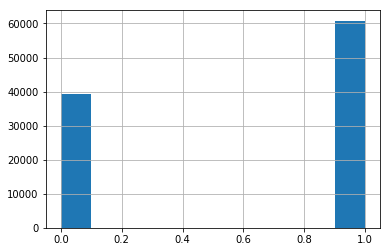

In [21]:
train.head(100000).NewEstimateTotal.hist()

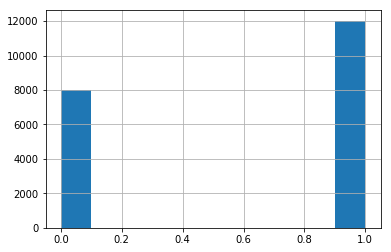

In [22]:
valid.head(20000).NewEstimateTotal.hist()

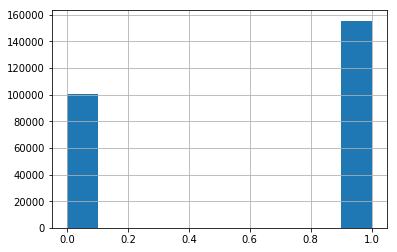

In [23]:
test.NewEstimateTotal.hist()

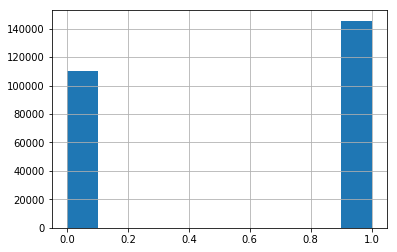

In [22]:
test.prediction.hist()